In [1]:
%cd ..

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from rdkit import Chem

/home/tox/Reactions


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.evaluator import Evaluator, ForwardEvaluator, BackwardEvaluator

In [4]:
def load_everything(evaluator):
    
    if mask_preds:=evaluator.load_pred_tokens() is False:
        return None
        
    if mask_mols:=evaluator.load_mols_strict() is False:
        return None

    return evaluator

In [5]:
from src.utils.extra import notation_table

In [6]:
notation_table

,color,name
notation,,
smiles,#ff8c8c,SMILES
selfies,#E8B86D,SELFIES
safe,#d9f2d0,SAFE
fragsmiles,#c1e5f5,fragSMILES


In [7]:
from src.language_conversion import decoding_fnc_of

# Loading Evaluators

In [ ]:
bestof_forward_setup = pd.read_csv('bestof_setup/best_forward_settings.csv')

In [9]:
bestof_forward_setup

,model_dim,num_heads,num_layers,batch_size,lr,dropout,notation,task
0,512,4,5,256,0.0001,0.3,fragsmiles,forward
1,512,4,5,256,0.0001,0.3,safe,forward
2,256,4,3,512,0.0010,0.3,selfies,forward
3,256,4,4,512,0.0010,0.3,smiles,forward


In [10]:
evaluators_forward = {kwargs['notation']:Evaluator.from_dict_args(kwargs)
    for kwargs in bestof_forward_setup.astype(str).to_dict('records')
}

In [11]:
for evaluator in evaluators_forward.values():
    load_everything(evaluator)

# Syntactycal Errors

In [12]:
from chemicalgof_refactored import Sequence2GoF, GoF2Mol

In [14]:
def get_invalid_errors(evaluator, fnc_convert=None):
    if fnc_convert is None:
        fnc_convert = decoding_fnc_of(evaluator.args.notation, error_handling=True, strict_chirality=True)

    invalids = evaluator.pred_tokens.loc[~evaluator.valids_strict[:,0],0]
    invalids = invalids.apply(lambda x: evaluator.vocab.translate_iterable ( x.tolist()[1:-1]  )  )
    if evaluator.args.notation != 'fragsmiles':
        invalids = invalids.apply(''.join)

    return invalids.apply(fnc_convert)

In [13]:
def fnc_fragsmiles(x):
	try:
		GoF2Mol(Sequence2GoF(x), strict_chirality=True)
	except Exception as e:
		return str(e)

In [15]:
errors_fragsmiles = get_invalid_errors(evaluators_forward['fragsmiles'], fnc_convert=fnc_fragsmiles)

In [16]:
errors_fragsmiles.tolist()

['Explicit valence for atom # 5 C, 5, is greater than permitted',
 "Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 8 9",
 'Branching Error : Some branching path has not been closed or opened',
 'Explicit valence for atom # 4 C, 5, is greater than permitted',
 'Bond Error : Invalid atom index for a fragment',
 'Explicit valence for atom # 4 O, 3, is greater than permitted',
 'Bond Error : Connecting atom index not specified for fragment: c1ccccc1 (index element #10).',
 'Branching Error : Some branching path has not been closed or opened',
 "Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 11 12 13 14 15",
 'Bond Error : Invalid atom index for a fragment',
 'Explicit valence for atom # 2 O, 3, is greater than permitted',
 'Explicit valence for atom # 2 O, 3, is greater than permitted',
 'Explicit valence for atom # 6 N, 4, is greater than permitted',
 'Explicit valence for atom # 6 N, 5, is greater than permitted',
 'Explicit valence for atom # 6 N, 5, is greater than permitted',
 "Ca

In [17]:
errors_forward = {
    notation : get_invalid_errors(evaluator)
    for notation, evaluator in evaluators_forward.items()
}

In [18]:
from src.language_conversion import ERRORS

In [19]:
ERRORS

['Rings', 'Kekulization', 'Bond Assignment', 'Brackets', 'Chirality', 'Misc.']

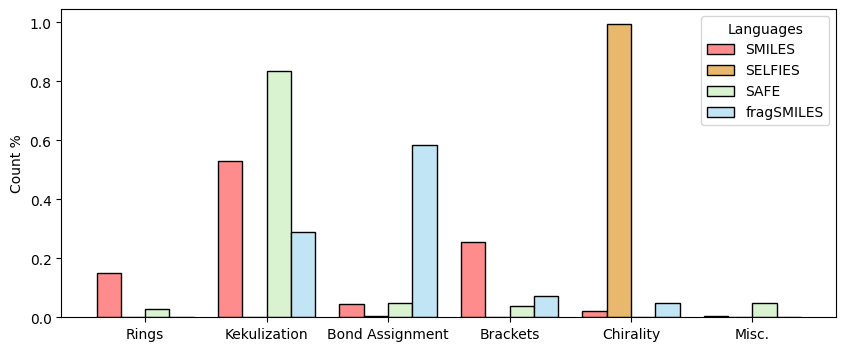

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

x = np.arange(len(ERRORS))

width = 0.2

for i, row in notation_table.reset_index().iterrows():
    total = len(errors_forward[row.notation])
    values = [(errors_forward[row.notation] == error).sum()/total for error in ERRORS]
    ax.bar(x + i * width, values, width, label=row['name'], color = row['color'], align='edge', edgecolor='black')

ax.set_ylabel('Count %')
ax.set_xticks(x + width*2) # 2 = len(notations) / 2 to center tick if 'align'=='edge' by ax.bar
ax.set_xticklabels(ERRORS)

ax.legend(title="Languages")


# Matched substructures among wrong predictions

In [21]:
# Loading substructures of test set (true targets)

target_fragments = pd.read_csv('data_reactions/test_fragments.csv')
target_fragments['cyclic'] = target_fragments['cyclic'].str.split(' ')
target_fragments['acyclic'] = target_fragments['acyclic'].str.split(' ')
mask_lengths = (ForwardEvaluator.test_lengths.smiles <=200) & (ForwardEvaluator.test_lengths.fragsmiles <=150)
target_fragments = target_fragments[mask_lengths]
target_fragments.fillna('', inplace=True)

In [22]:
from src.utils.chem import isolate_rings, isolate_side_chains
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter

In [23]:
def compare_frags(pred_frags: pd.Series, true_frags: pd.Series):
    kwargs = {}
    for col in true_frags.index:
        if len(pred_frags[col]) != len(true_frags[col]):
            kwargs[col] = False
        elif len(list((Counter(pred_frags[col]) & Counter(true_frags[col])).elements())) != len(true_frags[col]):
            kwargs[col] = False
        else:
            kwargs[col] = True

    kwargs['scaffold'] = pred_frags['scaffold'] == true_frags['scaffold']

    return pd.DataFrame([kwargs])
        
def get_matched_substructures(evaluator):
    mask_valid_wrong = ~evaluator.accurates_strict[:,0] & evaluator.valids_strict[:,0]
    pred_valid_wrong = evaluator.pred_mols_strict.loc[mask_valid_wrong,0]

    descriptions = pd.DataFrame()
    mols = pred_valid_wrong.apply(Chem.MolFromSmiles)

    descriptions['cyclic'] = mols.apply(isolate_rings)
    descriptions['acyclic'] = mols.apply(isolate_side_chains)
    descriptions['scaffold'] = pred_valid_wrong.apply(lambda x: MurckoScaffold.MurckoScaffoldSmiles(smiles=x, includeChirality=True) )

    rows = []
    for (_,pred_row), (_,true_row) in zip(descriptions.iterrows(), target_fragments[mask_valid_wrong].iterrows()):
        rows.append(compare_frags(pred_row, true_row))

    return pd.concat(rows, ignore_index=True)

In [24]:
fragments_forward = {
    notation : get_matched_substructures(evaluator)
    for notation, evaluator in evaluators_forward.items()
}

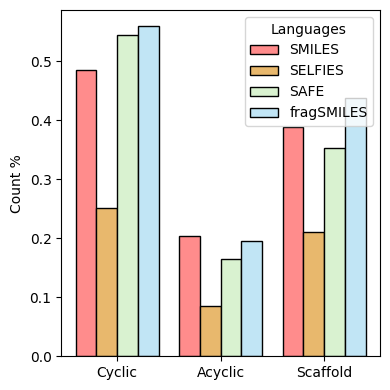

In [25]:
accuracy_errors = ['cyclic','acyclic', 'scaffold']

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

x = np.arange(len(accuracy_errors))

width = 0.2

for i, row in notation_table.reset_index().iterrows():
    matched = fragments_forward[row.notation]
    total = len(matched)
    values = [matched[error].sum()/total for error in accuracy_errors]
    ax.bar(x + i * width, values, width, label=row['name'], color = row['color'], align='edge', edgecolor='black')

ax.set_ylabel('Count %')
ax.set_xticks(x + width*2) # 2 = len(notations) / 2 to center tick if 'align'=='edge' by ax.bar
ax.set_xticklabels([x.capitalize() for x in accuracy_errors])

ax.legend(title="Languages")

plt.tight_layout()
plt.show()


# Join figures

In [26]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Arial'

/tmp/ipykernel_3417145/377894233.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
/tmp/ipykernel_3417145/377894233.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


Text(0.0, 1.0, 'b')

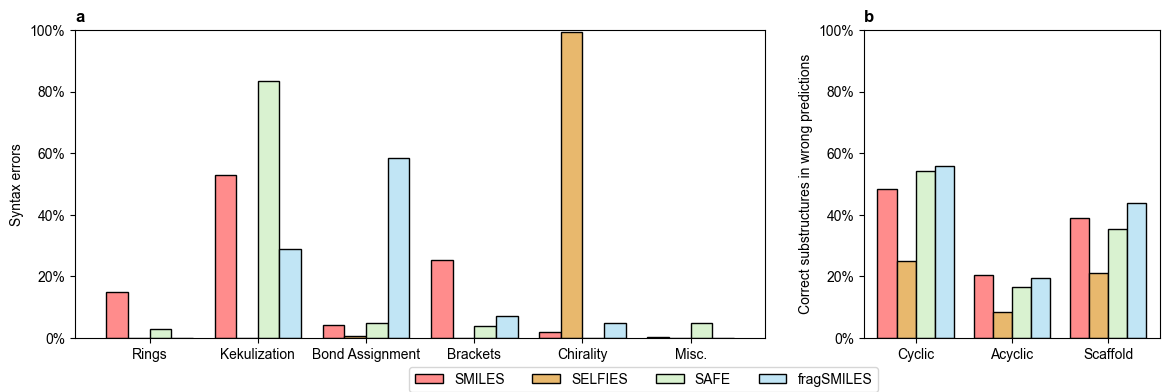

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), width_ratios=[0.7,0.3], sharey=True)

### a ###
ax = axes[0]
x = np.arange(len(ERRORS))

width = 0.2

for i, row in notation_table.reset_index().iterrows():
    total = len(errors_forward[row.notation])
    values = [(errors_forward[row.notation] == error).sum()/total for error in ERRORS]
    ax.bar(x + i * width, values, width, label=row['name'], color = row['color'], align='edge', edgecolor='black')

ax.set_ylabel('Syntax errors')
ax.set_xticks(x + width*2) # 2 = len(notations) / 2 to center tick if 'align'=='edge' by ax.bar
ax.set_xticklabels(ERRORS)

# manipulate y axis
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# ax.legend(loc="lower center", ncol=len(notation_table))
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(.35, 0), ncol=len(notation_table))

ax.set_title('a', loc='left', weight='bold')


### b ###
ax = axes[1]

accuracy_errors = ['cyclic','acyclic', 'scaffold']

x = np.arange(len(accuracy_errors))

width = 0.2

for i, row in notation_table.reset_index().iterrows():
    matched = fragments_forward[row.notation]
    total = len(matched)
    values = [matched[error].sum()/total for error in accuracy_errors]
    ax.bar(x + i * width, values, width, label=row['name'], color = row['color'], align='edge', edgecolor='black')

ax.set_ylabel('Correct substructures in wrong predictions')

ax.set_xticks(x + width*2) # 2 = len(notations) / 2 to center tick if 'align'=='edge' by ax.bar
ax.set_xticklabels([x.capitalize() for x in accuracy_errors])

# manipulate y axis
ax.set_ylim(0,1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.yaxis.set_tick_params(labelleft=True)

ax.set_title('b', loc='left', weight='bold')

In [28]:
fig.savefig('floats/figures/errors.pdf', bbox_inches='tight')